Set up environment and get dataset from Kaggle

In [9]:
import sys
import kagglehub
import os
import subprocess

# 1. Show the Python executable path
print("Python path:", sys.executable)

# 2. Show package versions using pip
def pkg_version(pkg_name):
    return subprocess.check_output(
        [sys.executable, "-m", "pip", "show", pkg_name],
        text=True
    ).split("Version: ")[1].splitlines()[0]

print("kaggle version:", pkg_version("kaggle"))
print("kagglehub version:", pkg_version("kagglehub"))

# 3. Download the AI-generated essays dataset
path = kagglehub.dataset_download("denvermagtibay/ai-generated-essays-dataset")
print("Dataset downloaded to:", path)

# 4. List the files in the dataset folder
print("Files in dataset folder:", os.listdir(path))


Python path: /Users/melody/projects/ai-essay-detection/.venv/bin/python
kaggle version: 1.7.4.5
kagglehub version: 0.3.12
Dataset downloaded to: /Users/melody/.cache/kagglehub/datasets/denvermagtibay/ai-generated-essays-dataset/versions/1
Files in dataset folder: ['AI Generated Essays Dataset.csv']


Preview first few rows of the csv

In [10]:
import pandas as pd
import os

# Re-set the dataset path (adjust to your actual downloaded path if needed)
dataset_path = kagglehub.dataset_download("denvermagtibay/ai-generated-essays-dataset")
files = os.listdir(dataset_path)

# Load the first CSV file from the dataset folder
csv_files = [f for f in files if f.lower().endswith(".csv")]
if csv_files:
    file_path = os.path.join(dataset_path, csv_files[0])
    print(f"Loading {csv_files[0]}...\n")
    df = pd.read_csv(file_path)
    print("Dataset preview:")
    display(df.head())
else:
    print("No CSV files found — check dataset folder contents.")


Loading AI Generated Essays Dataset.csv...

Dataset preview:


,text,generated
0,"Machine learning, a subset of artificial intel...",1
1,"A decision tree, a prominent machine learning ...",1
2,"Education, a cornerstone of societal progress,...",1
3,"Computers, the backbone of modern technology, ...",1
4,"Chess, a timeless game of strategy and intelle...",1


Extract features from string

In [11]:
import re, math, os
from collections import Counter
from itertools import islice

# --- minimal utilities ---
def sentences(text):
    # simple sentence splitter
    return [s.strip() for s in re.split(r'(?<=[.!?])\s+', text) if s.strip()]

def words(text):
    return re.findall(r"[A-Za-z]+(?:'[A-Za-z]+)?|\d+(?:\.\d+)?", text)

def ngrams(tokens, n=3):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

BASIC_STOPWORDS = {
    'the','a','an','and','or','but','if','then','so','because','as','of','in','on','for','to','with','by',
    'is','are','was','were','be','been','being','it','that','this','these','those','at','from','which',
    'we','you','they','he','she','i','me','my','our','your','their','its'
}

CONNECTIVES = [
    "however", "moreover", "furthermore", "additionally", "in conclusion",
    "in summary", "on the other hand", "in contrast", "nevertheless", "nonetheless",
    "therefore", "thus", "consequently", "overall", "first", "second", "third"
]
CONNECTIVE_RE = re.compile(r"\b(" + "|".join(map(re.escape, CONNECTIVES)) + r")\b", flags=re.I)

PASSIVE_RE = re.compile(r"\b(?:is|are|was|were|be|been|being)\s+\w+ed\b", flags=re.I)

def analyze_text(text):
    txt = (text or "").strip()
    toks = words(txt)
    sents = sentences(txt)
    if not toks or not sents:
        return {
            "word_count": 0, "sent_count": 0, "mean_sent_len": 0, "var_sent_len": 0,
            "ttr": 0, "stopword_ratio": 0, "trigram_repeat_ratio": 0,
            "connectives_per_100w": 0, "named_like_per_100w": 0,
            "digits_per_100w": 0, "passive_per_100w": 0, "punct_types": 0
        }

    # length & rhythm
    sent_lens = [len(words(s)) for s in sents]
    mean_len = sum(sent_lens)/len(sent_lens)
    var_len = sum((l-mean_len)**2 for l in sent_lens)/len(sent_lens)

    # lexical diversity
    wc = len(toks)
    unique = len(set(w.lower() for w in toks))
    ttr = unique / wc
    stop_ratio = sum(1 for w in toks if w.lower() in BASIC_STOPWORDS) / wc

    # repetition (trigram)
    tgs = ngrams([w.lower() for w in toks], 3)
    tg_counts = Counter(tgs)
    repeated = sum(c for tg, c in tg_counts.items() if c >= 2)
    trigram_repeat_ratio = (repeated / max(1, len(tgs)))

    # discourse/connectives
    conn = len(CONNECTIVE_RE.findall(txt))
    connectives_per_100w = 100 * conn / wc

    # specificity proxies (no spaCy): “named-like” = capitalized words not at sentence start
    named_like = re.findall(r"(?<![.!?]\s)(\b[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*)", txt)
    named_like_per_100w = 100 * len(named_like) / wc
    digits_per_100w = 100 * len(re.findall(r"\b\d", txt)) / wc

    # passive voice proxy
    passive_per_100w = 100 * len(PASSIVE_RE.findall(txt)) / wc

    # punctuation variety
    puncts = set(re.findall(r"[;:—–\-(),\"'…!?]", txt))
    punct_types = len(puncts)

    return {
        "word_count": wc,
        "sent_count": len(sents),
        "mean_sent_len": mean_len,
        "var_sent_len": var_len,
        "ttr": ttr,
        "stopword_ratio": stop_ratio,
        "trigram_repeat_ratio": trigram_repeat_ratio,
        "connectives_per_100w": connectives_per_100w,
        "named_like_per_100w": named_like_per_100w,
        "digits_per_100w": digits_per_100w,
        "passive_per_100w": passive_per_100w,
        "punct_types": punct_types,
    }


Introduce scoring for AI-likeliness (V1)

In [12]:
import pandas as pd
import numpy as np

# 1) pick the text column (auto-guess, or set manually)
TEXT_COL = None
candidates = [c for c in df.columns if str(df[c].dtype) == 'object']
name_hints = ['text','essay','content','body','response','statement','article']
for c in df.columns:
    if any(h in c.lower() for h in name_hints):
        TEXT_COL = c
        break
if TEXT_COL is None and candidates:
    TEXT_COL = candidates[0]  # fallback
print("Using text column:", TEXT_COL)

# 2) compute features
feat_rows = []
for i, t in df[TEXT_COL].fillna("").items():
    feat_rows.append(analyze_text(str(t)))
feat_df = pd.DataFrame(feat_rows, index=df.index)

# 3) simple rule-based score (0–5). Tweak thresholds after you see distributions.
def score_row(r):
    s = 0
    # (a) unusually uniform sentences → lower variance is more AI-like
    if r["var_sent_len"] <= 12: s += 1
    # (b) high templatey connectives
    if r["connectives_per_100w"] >= 3: s += 1
    # (c) low specificity proxies
    if r["named_like_per_100w"] < 0.8 and r["digits_per_100w"] < 0.6: s += 1
    # (d) repetition of phrasing
    if r["trigram_repeat_ratio"] >= 0.02: s += 1
    # (e) mid-range lexical diversity (optional heuristic)
    if 0.35 <= r["ttr"] <= 0.55: s += 1
    return s

feat_df["ai_likelihood_score"] = feat_df.apply(score_row, axis=1)
feat_df["ai_flag_simple"] = feat_df["ai_likelihood_score"] >= 2  # threshold you can adjust

# 4) quick look
display(feat_df.describe().T[["mean","50%","min","max"]])
print("\nFlag rate (simple):", feat_df["ai_flag_simple"].mean().round(3))

# 5) join back for inspection
scored = pd.concat([df[[TEXT_COL]].copy(), feat_df], axis=1)
display(scored.head(10))


Using text column: text


,mean,50%,min,max
word_count,536.467123,516.000000,36.000000,1365.000000
sent_count,25.856164,25.000000,2.000000,82.000000
mean_sent_len,21.534163,20.590909,10.711538,95.285714
var_sent_len,129.488970,95.645663,0.250000,1206.330579
ttr,0.448054,0.439727,0.270362,0.842105
stopword_ratio,0.366105,0.368573,0.202435,0.456914
trigram_repeat_ratio,0.081789,0.068776,0.000000,0.323970
connectives_per_100w,0.296337,0.220507,0.000000,1.630435
named_like_per_100w,4.265712,4.068377,0.000000,15.000000
digits_per_100w,0.990040,0.781250,0.000000,5.947955



Flag rate (simple): 0.818


,text,word_count,sent_count,mean_sent_len,var_sent_len,ttr,stopword_ratio,trigram_repeat_ratio,connectives_per_100w,named_like_per_100w,digits_per_100w,passive_per_100w,punct_types,ai_likelihood_score,ai_flag_simple
0,"Machine learning, a subset of artificial intel...",96,4,24.000000,12.000000,0.739583,0.312500,0.000000,0.000000,1.041667,0.000000,0.000000,1,1,False
1,"A decision tree, a prominent machine learning ...",105,6,17.500000,19.583333,0.761905,0.238095,0.000000,0.952381,0.000000,0.000000,0.952381,2,1,False
2,"Education, a cornerstone of societal progress,...",95,5,19.000000,31.200000,0.800000,0.242105,0.000000,1.052632,1.052632,0.000000,0.000000,2,0,False
3,"Computers, the backbone of modern technology, ...",92,5,18.400000,24.640000,0.771739,0.271739,0.000000,0.000000,1.086957,0.000000,0.000000,1,0,False
4,"Chess, a timeless game of strategy and intelle...",112,6,18.666667,14.555556,0.732143,0.285714,0.000000,0.000000,0.892857,0.892857,0.000000,3,0,False
5,"Calculus, a cornerstone of mathematical explor...",129,6,21.500000,20.916667,0.674419,0.325581,0.015748,0.000000,2.325581,0.775194,0.000000,2,0,False
6,"Electronics, the backbone of modern technology...",122,6,20.333333,29.888889,0.688525,0.336066,0.000000,0.000000,4.918033,0.000000,0.000000,5,0,False
7,"Data Science, a multidisciplinary field at the...",129,6,21.500000,33.583333,0.744186,0.255814,0.000000,0.000000,0.775194,0.000000,0.000000,2,1,False
8,"Artificial Intelligence (AI), a branch of comp...",121,6,20.166667,10.138889,0.776860,0.256198,0.000000,0.000000,1.652893,0.000000,0.000000,4,1,False
9,"Laptops, compact and portable computing device...",123,6,20.500000,10.583333,0.747967,0.317073,0.000000,0.000000,0.813008,0.000000,0.000000,2,1,False


Compare with original generated field

In [13]:
# New cell — show text, simple flag, and original generated column
TEXT_COL_NAME = TEXT_COL  # from Cell 2
LABEL_COL_NAME = "generated"  # replace if your column has a different name

comparison_df = df[[TEXT_COL_NAME, LABEL_COL_NAME]].copy()
comparison_df["ai_flag_simple"] = feat_df["ai_flag_simple"]

display(comparison_df.head(10))


,text,generated,ai_flag_simple
0,"Machine learning, a subset of artificial intel...",1,False
1,"A decision tree, a prominent machine learning ...",1,False
2,"Education, a cornerstone of societal progress,...",1,False
3,"Computers, the backbone of modern technology, ...",1,False
4,"Chess, a timeless game of strategy and intelle...",1,False
5,"Calculus, a cornerstone of mathematical explor...",1,False
6,"Electronics, the backbone of modern technology...",1,False
7,"Data Science, a multidisciplinary field at the...",1,False
8,"Artificial Intelligence (AI), a branch of comp...",1,False
9,"Laptops, compact and portable computing device...",1,False


Accuracy of the current scoring analysis

In [14]:
import pandas as pd
import numpy as np

# Column names carried over from earlier cells:
TEXT_COL_NAME = TEXT_COL              # from Cell 2 auto-detect or manual set
LABEL_COL_NAME = "generated"          # <-- change if your CSV uses a different label name

# 1) Build comparison frame
comparison_df = pd.DataFrame({
    "text": df[TEXT_COL_NAME],
    "ai_flag_simple": feat_df["ai_flag_simple"]
})

# 2) Normalize original label to boolean (AI=True, Human=False) where possible
def normalize_label(val):
    if pd.isna(val):
        return np.nan
    s = str(val).strip().lower()
    true_vals = {"1","true","yes","ai","generated","ai_generated","is_ai","is_generated"}
    false_vals = {"0","false","no","human","not_generated","is_human"}
    if s in true_vals:
        return True
    if s in false_vals:
        return False
    # try numeric
    try:
        return bool(int(s))
    except:
        return np.nan

if LABEL_COL_NAME in df.columns:
    comparison_df["generated_label"] = df[LABEL_COL_NAME].apply(normalize_label)
else:
    raise ValueError(f"Label column '{LABEL_COL_NAME}' not found. Update LABEL_COL_NAME to match your CSV.")

# 3) Drop rows without a usable ground-truth label
eval_df = comparison_df.dropna(subset=["generated_label"]).copy()

# 4) Compute metrics
y_true = eval_df["generated_label"].astype(bool).values
y_pred = eval_df["ai_flag_simple"].astype(bool).values

tp = int(((y_pred == True)  & (y_true == True)).sum())
tn = int(((y_pred == False) & (y_true == False)).sum())
fp = int(((y_pred == True)  & (y_true == False)).sum())
fn = int(((y_pred == False) & (y_true == True)).sum())

def safe_div(a, b): 
    return (a / b) if b else 0.0

accuracy  = safe_div(tp + tn, tp + tn + fp + fn)
precision = safe_div(tp, tp + fp)   # P(pred=AI | AI)
recall    = safe_div(tp, tp + fn)   # P(pred=AI | true AI)
f1        = safe_div(2*precision*recall, precision + recall)

print(f"Evaluated on {len(eval_df)} rows (dropped {len(comparison_df)-len(eval_df)} unlabeled/unknown).")
print("\nConfusion matrix (rows=true, cols=pred):")
print(pd.DataFrame([[tn, fp],[fn, tp]], 
                   index=["Human", "AI"], 
                   columns=["Pred Human","Pred AI"]))

print("\nMetrics (AI = positive class):")
print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1       : {f1:.3f}")

# 5) Peek at a few examples that disagree (useful for threshold tuning)
disagreements = eval_df[eval_df["ai_flag_simple"] != eval_df["generated_label"]].head(5)
print("\nSample disagreements (showing first 5):")
display(disagreements[["text","generated_label","ai_flag_simple"]])


Evaluated on 1460 rows (dropped 0 unlabeled/unknown).

Confusion matrix (rows=true, cols=pred):
       Pred Human  Pred AI
Human         196     1179
AI             70       15

Metrics (AI = positive class):
Accuracy : 0.145
Precision: 0.013
Recall   : 0.176
F1       : 0.023

Sample disagreements (showing first 5):


,text,generated_label,ai_flag_simple
0,"Machine learning, a subset of artificial intel...",True,False
1,"A decision tree, a prominent machine learning ...",True,False
2,"Education, a cornerstone of societal progress,...",True,False
3,"Computers, the backbone of modern technology, ...",True,False
4,"Chess, a timeless game of strategy and intelle...",True,False


Fixing scoring analysis for better accuracy (V2)

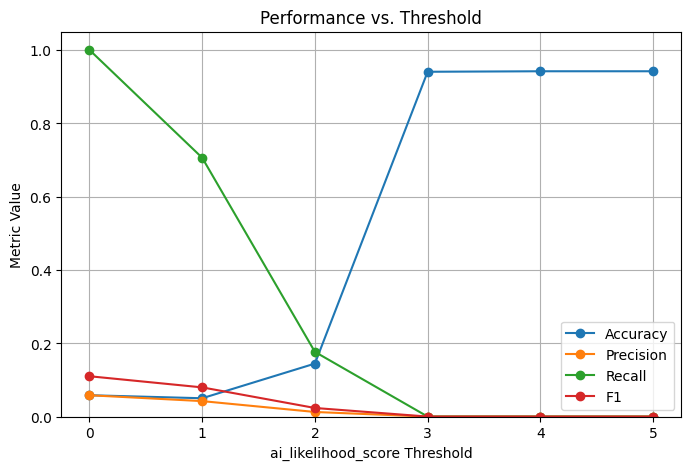

,threshold,accuracy,precision,recall,f1
0,0,0.058219,0.058219,1.000000,0.110032
1,1,0.050000,0.042194,0.705882,0.079628
2,2,0.144521,0.012563,0.176471,0.023456
3,3,0.940411,0.000000,0.000000,0.000000
4,4,0.941781,0.000000,0.000000,0.000000
5,5,0.941781,0.000000,0.000000,0.000000


,threshold,accuracy,precision,recall,f1
0,0,0.058219,0.058219,1.000000,0.110032
1,1,0.050000,0.042194,0.705882,0.079628
2,2,0.144521,0.012563,0.176471,0.023456
3,3,0.940411,0.000000,0.000000,0.000000
4,4,0.941781,0.000000,0.000000,0.000000
5,5,0.941781,0.000000,0.000000,0.000000


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make sure we still have the normalized label
if "generated_label" not in comparison_df.columns:
    comparison_df["generated_label"] = df[LABEL_COL_NAME].apply(normalize_label)

# Only evaluate rows with a known label
eval_df = pd.concat([feat_df["ai_likelihood_score"], comparison_df["generated_label"], df[TEXT_COL_NAME]], axis=1).dropna(subset=["generated_label"])
y_true = eval_df["generated_label"].astype(bool).values

thresholds = range(0, 6)  # score cutoffs from 0 to 5
results = []

for t in thresholds:
    y_pred = (eval_df["ai_likelihood_score"] >= t).values
    
    tp = int(((y_pred == True)  & (y_true == True)).sum())
    tn = int(((y_pred == False) & (y_true == False)).sum())
    fp = int(((y_pred == True)  & (y_true == False)).sum())
    fn = int(((y_pred == False) & (y_true == True)).sum())
    
    def safe_div(a, b): return (a / b) if b else 0.0
    
    accuracy  = safe_div(tp + tn, tp + tn + fp + fn)
    precision = safe_div(tp, tp + fp)
    recall    = safe_div(tp, tp + fn)
    f1        = safe_div(2*precision*recall, precision + recall)
    
    results.append({
        "threshold": t,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })

# Create DataFrame
res_df = pd.DataFrame(results)

# Plot metrics vs threshold
plt.figure(figsize=(8,5))
plt.plot(res_df["threshold"], res_df["accuracy"], marker="o", label="Accuracy")
plt.plot(res_df["threshold"], res_df["precision"], marker="o", label="Precision")
plt.plot(res_df["threshold"], res_df["recall"], marker="o", label="Recall")
plt.plot(res_df["threshold"], res_df["f1"], marker="o", label="F1")
plt.xlabel("ai_likelihood_score Threshold")
plt.ylabel("Metric Value")
plt.ylim(0, 1.05)
plt.xticks(thresholds)
plt.title("Performance vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Show table of results
display(res_df)

res_df.sort_values("recall", ascending=False)



Build a feature matrix

In [18]:
# X = features, y = ground truth
X = feat_df[[
    "var_sent_len","connectives_per_100w","named_like_per_100w","digits_per_100w",
    "trigram_repeat_ratio","ttr","word_count","punct_types","passive_per_100w","mean_sent_len","sent_count"
]].fillna(0)

y = comparison_df["generated_label"].astype(bool)


Train lightweight model: logistic regression with scaling (V3)

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, precision_recall_curve

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear")),
])

# Probability calibration improves threshold tuning
cal_clf = CalibratedClassifierCV(pipe, method="isotonic", cv=3)
cal_clf.fit(Xtr, ytr)

probs = cal_clf.predict_proba(Xte)[:,1]


Compute with rule-based accuracy

Rule-based baseline accuracy (test split): 0.134

Best threshold meeting accuracy>=baseline:
{'thr': 0.195, 'f1': 1.0, 'prec': 1.0, 'rec': 1.0, 'acc': 1.0}


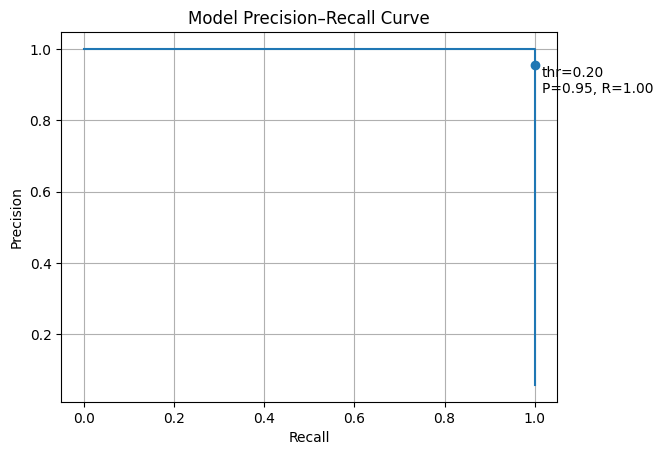

,threshold,precision,recall,f1,accuracy
0,0.000,0.057534,1.0,0.108808,0.057534
1,0.005,0.875000,1.0,0.933333,0.991781
2,0.010,0.875000,1.0,0.933333,0.991781
3,0.015,0.875000,1.0,0.933333,0.991781
4,0.020,0.875000,1.0,0.933333,0.991781


,threshold,precision,recall,f1,accuracy
59,0.295,1.0,1.0,1.0,1.0
74,0.370,1.0,1.0,1.0,1.0
54,0.270,1.0,1.0,1.0,1.0
53,0.265,1.0,1.0,1.0,1.0
52,0.260,1.0,1.0,1.0,1.0
51,0.255,1.0,1.0,1.0,1.0
50,0.250,1.0,1.0,1.0,1.0
49,0.245,1.0,1.0,1.0,1.0
48,0.240,1.0,1.0,1.0,1.0
47,0.235,1.0,1.0,1.0,1.0


In [21]:
# Continue from your code where `probs`, Xte, yte exist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, precision_recall_curve

# --- 1) Baseline from your earlier rule-based flags on the same test split ---
# Requires feat_df["ai_flag_simple"] from the earlier rule-based step, aligned by index to X.
try:
    y_baseline_pred = feat_df.loc[Xte.index, "ai_flag_simple"].astype(bool).values
    baseline_acc = accuracy_score(yte, y_baseline_pred)
    print(f"Rule-based baseline accuracy (test split): {baseline_acc:.3f}")
except Exception as e:
    baseline_acc = 0.0
    print("Couldn't compute rule-based baseline (fallback to 0.0). Error:", e)

# --- 2) Threshold sweep under an accuracy constraint ---
thresholds = np.linspace(0, 1, 201)
best = {"thr": 0.5, "f1": -1, "prec": 0, "rec": 0, "acc": 0}

for t in thresholds:
    yhat = (probs >= t)
    prec, rec, f1, _ = precision_recall_fscore_support(yte, yhat, average="binary", zero_division=0)
    acc = accuracy_score(yte, yhat)
    if acc >= baseline_acc and f1 > best["f1"]:
        best = {"thr": float(t), "f1": float(f1), "prec": float(prec), "rec": float(rec), "acc": float(acc)}

print("\nBest threshold meeting accuracy>=baseline:")
print(best)

# Full table if you want to inspect all thresholds:
rows = []
for t in thresholds:
    yhat = (probs >= t)
    prec, rec, f1, _ = precision_recall_fscore_support(yte, yhat, average="binary", zero_division=0)
    acc = accuracy_score(yte, yhat)
    rows.append({"threshold": t, "precision": prec, "recall": rec, "f1": f1, "accuracy": acc})
res_df_model = pd.DataFrame(rows)

# --- 3) Precision–Recall curve for the model probabilities ---
precisions, recalls, pr_thresholds = precision_recall_curve(yte, probs)

plt.figure()
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Model Precision–Recall Curve")
plt.grid(True)

# mark the chosen threshold on the PR curve (nearest point)
if len(pr_thresholds):
    # find nearest PR point to best['thr']
    idx = np.argmin(np.abs(pr_thresholds - best["thr"]))
    plt.scatter(recalls[idx], precisions[idx])
    plt.annotate(f"thr={best['thr']:.2f}\nP={precisions[idx]:.2f}, R={recalls[idx]:.2f}",
                 (recalls[idx], precisions[idx]), xytext=(5, -20), textcoords="offset points")

plt.show()

# Also show metrics vs threshold for reference
display(res_df_model.head())
display(res_df_model.sort_values("f1", ascending=False).head(10))


Count of accurate detection of AI generation

In [22]:
import numpy as np
import pandas as pd

# Use the chosen threshold
chosen_threshold = 0.20  # from your PR curve

# Predictions from model
y_pred = (probs >= chosen_threshold)

# Confusion matrix counts
tp = int(((y_pred == True)  & (yte == True)).sum())   # AI essays correctly flagged as AI
tn = int(((y_pred == False) & (yte == False)).sum())  # Human essays correctly left unflagged
fp = int(((y_pred == True)  & (yte == False)).sum())  # Human essays incorrectly flagged as AI
fn = int(((y_pred == False) & (yte == True)).sum())   # AI essays missed (predicted human)

print(f"Correct AI detections (True Positives): {tp}")
print(f"Correct Human detections (True Negatives): {tn}")
print(f"Incorrectly flagged Humans (False Positives): {fp}")
print(f"Missed AI essays (False Negatives): {fn}")
print(f"\nTotal in test set: {len(yte)}")


Correct AI detections (True Positives): 21
Correct Human detections (True Negatives): 344
Incorrectly flagged Humans (False Positives): 0
Missed AI essays (False Negatives): 0

Total in test set: 365


Run stratified K fold for cross-validation (V4)

In [23]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np

# Use the same features and labels from before
X_cv = X  # from earlier: feat_df[feature_columns]
y_cv = y  # from earlier: comparison_df["generated_label"]

# Define Stratified K-fold (e.g., 5 folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model pipeline (same as before, without explicit calibration for simplicity)
pipe_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear")),
])

# Evaluate precision, recall, accuracy, f1 across folds
scoring = ["accuracy", "precision", "recall", "f1"]
cv_results = cross_validate(pipe_cv, X_cv, y_cv, cv=kf, scoring=scoring, return_train_score=False)

# Print mean and std for each metric
for metric in scoring:
    mean_score = np.mean(cv_results[f"test_{metric}"])
    std_score = np.std(cv_results[f"test_{metric}"])
    print(f"{metric.capitalize():<10} : {mean_score:.3f} ± {std_score:.3f}")


Accuracy   : 0.984 ± 0.004
Precision  : 0.789 ± 0.044
Recall     : 1.000 ± 0.000
F1         : 0.882 ± 0.027


Find the better trade-off point for higher accuracy and precision (V5)

In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# --- Inputs ---
# probs: model scores on test set (from your calibrated logistic)
# yte:   true labels (boolean array/Series: True=AI, False=Human)

RECALL_FLOOR = 0.98   # keep recall high (catch ≥98% of AI)
ACC_FLOOR    = None   # optionally set e.g., 0.98 to enforce accuracy; or leave None

thresholds = np.linspace(0, 1, 201)

rows = []
for t in thresholds:
    y_pred = (probs >= t)
    tp = int(((y_pred == True)  & (yte == True)).sum())
    tn = int(((y_pred == False) & (yte == False)).sum())
    fp = int(((y_pred == True)  & (yte == False)).sum())
    fn = int(((y_pred == False) & (yte == True)).sum())

    prec = precision_score(yte, y_pred, zero_division=0)
    rec  = recall_score(yte, y_pred, zero_division=0)
    acc  = accuracy_score(yte, y_pred)
    f1   = f1_score(yte, y_pred, zero_division=0)

    rows.append({
        "threshold": t, "precision": prec, "recall": rec, "accuracy": acc, "f1": f1,
        "TP": tp, "FP": fp, "FN": fn, "TN": tn
    })

res = pd.DataFrame(rows)

# Filter by constraints: keep recall high (and accuracy if you set ACC_FLOOR)
mask = res["recall"] >= RECALL_FLOOR
if ACC_FLOOR is not None:
    mask &= res["accuracy"] >= ACC_FLOOR

candidates = res[mask].copy()

print(f"Threshold candidates meeting recall ≥ {RECALL_FLOOR}"
      + (f" and accuracy ≥ {ACC_FLOOR}" if ACC_FLOOR is not None else "")
      + f": {len(candidates)}")

# (A) Best precision among candidates (fewest false positives)
best_by_precision = candidates.sort_values(["precision","threshold"], ascending=[False, True]).head(1)
print("\nBest (maximize precision under constraints):")
display(best_by_precision[["threshold","precision","recall","accuracy","f1","TP","FP","FN","TN"]])

# (B) Alternatively, explicitly minimize FP (ties broken by higher recall, then precision)
best_by_fp = candidates.sort_values(["FP","recall","precision","threshold"],
                                    ascending=[True, False, False, True]).head(1)
print("\nBest (minimize FP under constraints):")
display(best_by_fp[["threshold","precision","recall","accuracy","f1","TP","FP","FN","TN"]])

# Show the top few candidates so you can compare
print("\nTop candidates (sorted by precision desc):")
display(candidates.sort_values(["precision","threshold"], ascending=[False, True]).head(10))

print("\nTop candidates (sorted by FP asc):")
display(candidates.sort_values(["FP","recall","precision","threshold"],
                               ascending=[True, False, False, True]).head(10))


Threshold candidates meeting recall ≥ 0.98: 89

Best (maximize precision under constraints):


,threshold,precision,recall,accuracy,f1,TP,FP,FN,TN
39,0.195,1.0,1.0,1.0,1.0,21,0,0,344



Best (minimize FP under constraints):


,threshold,precision,recall,accuracy,f1,TP,FP,FN,TN
39,0.195,1.0,1.0,1.0,1.0,21,0,0,344



Top candidates (sorted by precision desc):


,threshold,precision,recall,accuracy,f1,TP,FP,FN,TN
39,0.195,1.0,1.0,1.0,1.0,21,0,0,344
40,0.200,1.0,1.0,1.0,1.0,21,0,0,344
41,0.205,1.0,1.0,1.0,1.0,21,0,0,344
42,0.210,1.0,1.0,1.0,1.0,21,0,0,344
43,0.215,1.0,1.0,1.0,1.0,21,0,0,344
44,0.220,1.0,1.0,1.0,1.0,21,0,0,344
45,0.225,1.0,1.0,1.0,1.0,21,0,0,344
46,0.230,1.0,1.0,1.0,1.0,21,0,0,344
47,0.235,1.0,1.0,1.0,1.0,21,0,0,344
48,0.240,1.0,1.0,1.0,1.0,21,0,0,344



Top candidates (sorted by FP asc):


,threshold,precision,recall,accuracy,f1,TP,FP,FN,TN
39,0.195,1.0,1.0,1.0,1.0,21,0,0,344
40,0.200,1.0,1.0,1.0,1.0,21,0,0,344
41,0.205,1.0,1.0,1.0,1.0,21,0,0,344
42,0.210,1.0,1.0,1.0,1.0,21,0,0,344
43,0.215,1.0,1.0,1.0,1.0,21,0,0,344
44,0.220,1.0,1.0,1.0,1.0,21,0,0,344
45,0.225,1.0,1.0,1.0,1.0,21,0,0,344
46,0.230,1.0,1.0,1.0,1.0,21,0,0,344
47,0.235,1.0,1.0,1.0,1.0,21,0,0,344
48,0.240,1.0,1.0,1.0,1.0,21,0,0,344


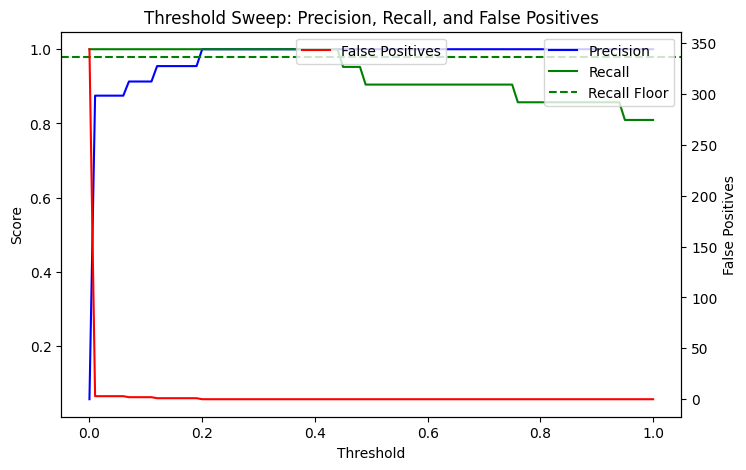

Best Threshold: 0.20
Precision at Best Threshold: 1.000
Recall at Best Threshold: 1.000
False Positives at Best Threshold: 0


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# We'll test thresholds between 0 and 1
thresholds = np.linspace(0, 1, 101)

precisions = []
recalls = []
false_positives = []

RECALL_FLOOR = 0.98  # we don't want recall to drop below this

for t in thresholds:
    preds = (probs >= t).astype(int)
    
    precisions.append(precision_score(yte, preds))
    recalls.append(recall_score(yte, preds))
    false_positives.append(np.sum((preds == 1) & (yte == 0)))

# Plot
fig, ax1 = plt.subplots(figsize=(8, 5))

# Precision & Recall
ax1.plot(thresholds, precisions, label="Precision", color="blue")
ax1.plot(thresholds, recalls, label="Recall", color="green")
ax1.axhline(RECALL_FLOOR, color="green", linestyle="--", label="Recall Floor")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Score")
ax1.legend(loc="upper right")

# False positives on second axis
ax2 = ax1.twinx()
ax2.plot(thresholds, false_positives, label="False Positives", color="red")
ax2.set_ylabel("False Positives")
ax2.legend(loc="upper center")

plt.title("Threshold Sweep: Precision, Recall, and False Positives")
plt.show()

# Find best threshold where recall >= floor and precision is max
best_idx = max(
    ((i, p) for i, (p, r) in enumerate(zip(precisions, recalls)) if r >= RECALL_FLOOR),
    key=lambda x: x[1]
)[0]

print(f"Best Threshold: {thresholds[best_idx]:.2f}")
print(f"Precision at Best Threshold: {precisions[best_idx]:.3f}")
print(f"Recall at Best Threshold: {recalls[best_idx]:.3f}")
print(f"False Positives at Best Threshold: {false_positives[best_idx]}")


Confusion Matrix

In [29]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import numpy as np

thresholds = np.linspace(0, 1, 101)
precisions = []
recalls = []

RECALL_FLOOR = 0.98

# Find best threshold based on precision while keeping recall >= RECALL_FLOOR
for t in thresholds:
    preds = (probs >= t).astype(int)
    precisions.append(precision_score(yte, preds))
    recalls.append(recall_score(yte, preds))

best_idx = max(
    ((i, p) for i, (p, r) in enumerate(zip(precisions, recalls)) if r >= RECALL_FLOOR),
    key=lambda x: x[1]
)[0]

best_threshold = thresholds[best_idx]
best_preds = (probs >= best_threshold).astype(int)
cm = confusion_matrix(yte, best_preds)

print("\nConfusion Matrix (rows: true, cols: predicted)")
print(cm)
print(f"TN: {cm[0,0]}, FP: {cm[0,1]}, FN: {cm[1,0]}, TP: {cm[1,1]}")



Confusion Matrix (rows: true, cols: predicted)
[[344   0]
 [  0  21]]
TN: 344, FP: 0, FN: 0, TP: 21


Feature Representation Bias

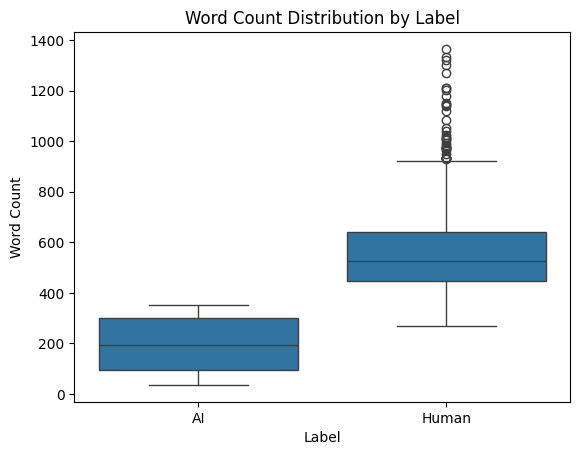

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Merge label onto your features
feat_with_label = feat_df.join(comparison_df["generated_label"])

# Optional: make the x-axis nicer to read
feat_with_label["label_str"] = feat_with_label["generated_label"].map({True: "AI", False: "Human"})

# Boxplot of word count by label
sns.boxplot(x="label_str", y="word_count", data=feat_with_label)
plt.title("Word Count Distribution by Label")
plt.xlabel("Label")
plt.ylabel("Word Count")
plt.show()


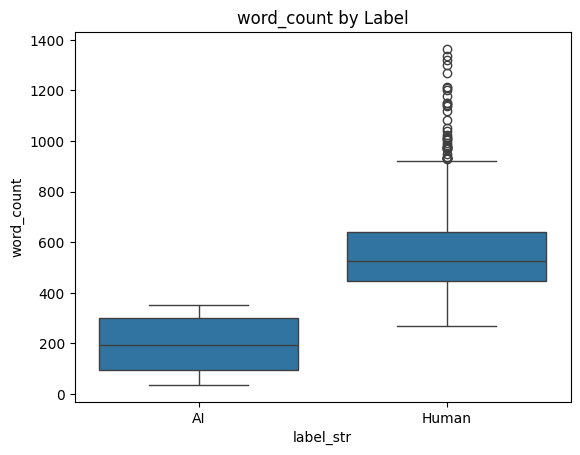

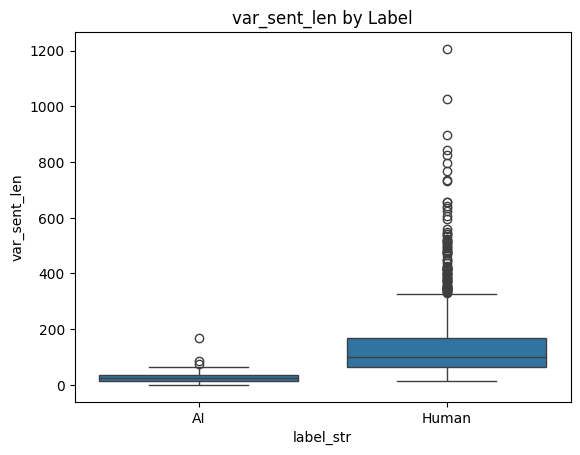

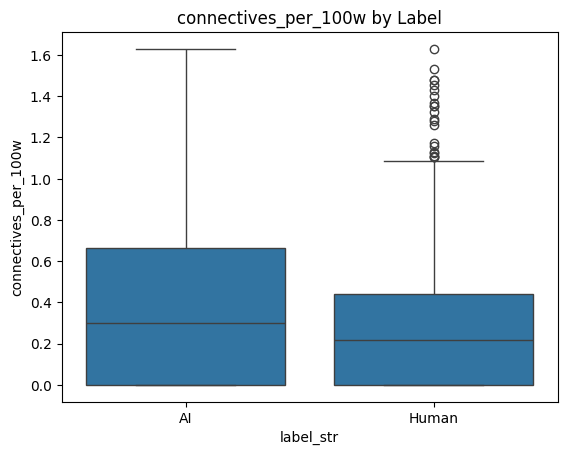

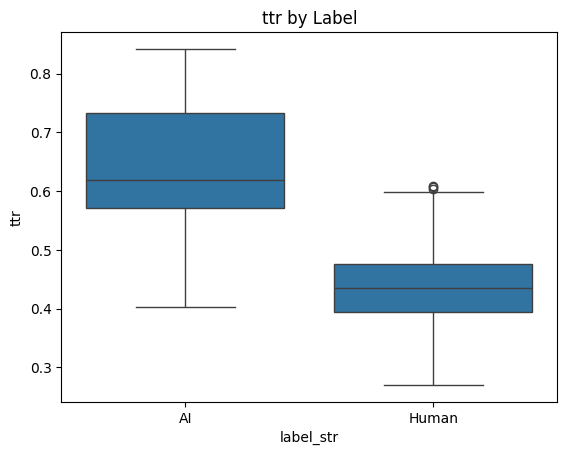

In [32]:
for col in ["word_count", "var_sent_len", "connectives_per_100w", "ttr"]:
    sns.boxplot(x="label_str", y=col, data=feat_with_label)
    plt.title(f"{col} by Label")
    plt.show()
